In [1]:
import re,os,glob,argparse,datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense,Input,Activation,Flatten,TimeDistributed,MaxPooling1D,AveragePooling1D,Dropout,BatchNormalization
from tensorflow.keras.layers import LSTM,Conv1D,GRU, Bidirectional, Flatten, add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from IPython import embed  #变量自动补全
%matplotlib inline

In [2]:
## Params validation_train_data
parser = argparse.ArgumentParser()
parser.add_argument('--model', default='ResNet', type=str, help='choose a type of model')
parser.add_argument('--batch_size', default=100, type=int, help='batch size')
parser.add_argument('--train_data', default='../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_train_noise/x', type=str, help='path of train data')
parser.add_argument('--label_data', default='../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_train_noise/y', type=str, help='path of label data')
parser.add_argument('--epoch', default=100, type=int, help='number of train epoches')
parser.add_argument('--lr', default=5e-4, type=float, help='initial learning rate for Adam')
parser.add_argument('--save_every', default=10, type=int, help='save model at every x epoches')
parser.add_argument('--time_series', default=200, type=int, help='The length of each sample')
parser.add_argument('--rows', default=201, type=int, help='The rows of each sample')
parser.add_argument('--feature', default=1, type=int, help='The feature number of input data ')
args = parser.parse_args(args=[]) #由于在jupyter notebook中，args不为空。
# args = parser.parse_args()      #spyder中语法

#m模型保存路径
save_dir = os.path.join('models',args.model) 
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 1、Load data

In [3]:
def gen_patches(file_name, rows=args.rows, columns=1): 
    # 剖面分块大小和分块步长,对训练数据和标签进行分切割分块
    # rows， columns输入数据的行数和列数
    
    patch_size, stride = args.time_series, 100
    
    # read txt
    f = open(file_name,'r+')
    text = f.read()
    text.replace('\n',';')     #将换行符替换成分隔符
    file_txt = np.mat(text)    #字符串矩阵转换为numpy数字矩阵
    file_txt=file_txt.reshape(rows,columns)
    h, w = file_txt.shape
    #print('w is', h)

    patches = []
    # extract patches
    for i in range(0, h-patch_size+1, stride):
        x = file_txt[i:i+patch_size, :]
        #print("Patch size is ",x.shape)
        patches.append(x)                        
    return patches

In [4]:
def datagenerator(data_dir='train_data/x',rows=args.rows, columns=1, verbose=False):
    # 对所有的训练数据进行切割个重新组合
    file_list = sorted(glob.glob(data_dir+'/*.txt'), key=os.path.getmtime)  # get name list of all magnetic .txt files

    # initrialize
    data = []
    # generate patches
    for i in range(len(file_list)):
        patch = gen_patches(file_list[i], rows, columns)
        data.append(patch)
        if verbose:
            print(str(i+1)+'/'+ str(len(file_list)) + ' is done ^_^')
    data = np.array(data)   # 图像的话需要, dtype='uint8'
    #print(data)
    #print(data.shape)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2],data.shape[3])) # data.shape[3]为特征维度
    print("Sample's dimension : ",data.shape)
    print('^_^-Training sample data finished-^_^')
    return data

In [6]:
def datagenerator_label(data_dir='train_data/y'):
    file_list = sorted(glob.glob(data_dir+'/*.txt'), key=os.path.getmtime)  # get name list of all label files
    # initrialize
    data = []
    # generate patches
    for file_name in file_list:
        f = open(file_name,'r+')
        text = f.read()
        text.replace('\n',';')     #将换行符替换成分隔符
        text = np.mat(text)    #字符串矩阵转换为numpy数字矩阵
        data.append(text)
            
    data = np.array(data)   # List to array
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
    print("Label's dimension : ",data.shape)
    print('^_^-Training Labels data finished-^_^')
    return data

In [8]:
def train_datagen(epoch_num=args.epoch,batch_size=args.batch_size,train_data_dir=args.train_data,label_data_dir=args.label_data,\
                  x_rows=args.rows,x_columns=1):
    while(True):
        n_count = 0
        if n_count == 0:
            #print(n_count)
            # Samples Preprocessing
            xs = datagenerator(train_data_dir, rows=x_rows, columns=x_columns)
            assert len(xs)%args.batch_size ==0, \
            log('make sure the last iteration has a full batchsize, this is important if you use batch normalization!')
            xs = xs.astype('float32')
            # 归一化数据
            scaler_x = MinMaxScaler(feature_range=(0, 1))
            for i_xs in range(xs.shape[0]):
                xs[i_xs] = scaler_x.fit_transform(xs[i_xs])
            
            # Labels 
            ys = datagenerator_label(label_data_dir)
            ys = ys.astype('float32')
            ys1 = ys  # Becasue of classification, delete the second and third column.
            print("Updated Label's dimension :", ys1.shape)
            
            indices = list(range(xs.shape[0]))
            #print('Data length is ',len(indices))
            n_count = 1
        for num in range(epoch_num):
            #print('epoch_num:', num)
            np.random.shuffle(indices)    # shuffle
            for i in range(0, len(indices), batch_size):
                batch_x = xs[indices[i:i+batch_size]]
                batch_y = ys1[indices[i:i+batch_size]]
                """print('\nbatch_x shape : ',batch_x.shape)
                print('batch_y shape : ',batch_y.shape)
                print('\n')"""
                yield batch_x, [batch_y[:,0],batch_y[:,1]]

In [11]:
def log(*args,**kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"),*args,**kwargs)

def lr_schedule(epoch):
    initial_lr = args.lr
    if epoch<=30:
        lr = initial_lr
    elif epoch<=60:
        lr = initial_lr/10
    elif epoch<=80:
        lr = initial_lr/20 
    else:
        lr = initial_lr/20 
    log('current learning rate is %2.8f' %lr)
    return lr

# 2、Build model

In [12]:
# 定义残差块
def res_block_v1(x, input_filter, output_filter):
    res_x =  Conv1D(filters=output_filter, kernel_size=3, strides=1, padding='same')(x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation('relu')(res_x)
    res_x =  Conv1D(filters=output_filter, kernel_size=3, strides=1, padding='same')(res_x)
    res_x = BatchNormalization()(res_x)
    
    if input_filter == output_filter:
        identity = x
    else:
        identity = Conv1D(filters=output_filter, kernel_size=1, strides=1, padding='same')(x)
    
    x = add([identity, res_x])
    output = Activation('relu')(x)
    
    return output

In [13]:
inputs = Input(shape=[args.time_series, args.feature])  
x = Conv1D(filters=60, kernel_size=3, strides=1, padding='same', input_shape=[None,1], activation='relu')(inputs)
x = AveragePooling1D(pool_size=2)(x)
x = Dropout(0.1)(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Conv1D(filters=120, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = AveragePooling1D(pool_size=2)(x)
x = Dropout(0.1)(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Conv1D(filters=180, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = AveragePooling1D(pool_size=2)(x)
x = Dropout(0.1)(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Conv1D(filters=240, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = AveragePooling1D(pool_size=5)(x)
x = Dropout(0.1)(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

# # 残差块
x = res_block_v1(x, 240, 120)
x = res_block_v1(x, 120, 240)
x = res_block_v1(x, 240, 240)

# 位置回归

x = Flatten()(x)
# 水平位置回归
x_loc = Dense(units=240, activation='relu')(x)
# x_loc = Dropout(0.1)(x_loc)
x_loc = Dense(units=60, activation='relu')(x_loc)
# x_loc = Dropout(0.1)(x_loc)
x_loc = Dense(units=1, activation='linear', name = 'Horizontal_position')(x_loc)

# 深度回归
x_depth = Dense(units=240, activation='relu')(x)
# x_depth = Dropout(0.1)(x_depth)
x_depth = Dense(units=60, activation='relu')(x_depth)
# x_depth = Dropout(0.1)(x_depth)
x_depth = Dense(units=1, activation='linear', name = 'Depth')(x_depth)

outputs = [x_loc, x_depth]
model = Model(inputs=inputs,outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 60)      240         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling1d (AveragePooli (None, 100, 60)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 60)      0           average_pooling1d[0][0]          
______________________________________________________________________________________________

In [14]:
# load the last model in matconvnet style
"""initial_epoch = findLastCheckpoint(save_dir=save_dir)
if initial_epoch > 0:  
    print('resuming by loading epoch %03d'%initial_epoch)
    model = load_model(os.path.join(save_dir,'model_%03d.hdf5'%initial_epoch), compile=False)"""
    
# compile the model
# model.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')
# model.compile(optimizer='adam',loss=['mse','mse'], metrics=['accuracy'])   #loss='mean_squared_error'
model.compile(optimizer='adam',loss=['mse','mse'], metrics=['accuracy'], loss_weights=[1,2])   #loss='mean_squared_error'

# plot graph of model
#plot_model(model, to_file='figures/model.png', show_shapes=True)
    
# use call back functions
checkpointer = ModelCheckpoint(os.path.join(save_dir,'model_{epoch:03d}.hdf5'), 
            verbose=1, save_weights_only=False, period=args.save_every)
## 输出训练后的损失值等的日子文件
csv_logger = CSVLogger(os.path.join(save_dir,'log.csv'), append=False, separator=',')
lr_scheduler = LearningRateScheduler(lr_schedule)   #学习率调用程序

#  3、 Train model

In [15]:
history = model.fit(train_datagen(batch_size=args.batch_size), epochs=args.epoch, steps_per_epoch=1000, verbose=2,
         initial_epoch=0,\
        validation_data=train_datagen(batch_size=args.batch_size, \
        train_data_dir='../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_validation/x',\
        label_data_dir='../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_validation/y'), \
        validation_steps=200,\
        callbacks=[checkpointer,csv_logger,lr_scheduler])

Sample's dimension :  (100000, 200, 1)
^_^-Training sample data finished-^_^
Label's dimension :  (100000, 2)
^_^-Training Labels data finished-^_^
Updated Label's dimension : (100000, 2)
Sample's dimension :  (20000, 200, 1)
^_^-Training sample data finished-^_^
Label's dimension :  (20000, 2)
^_^-Training Labels data finished-^_^
Updated Label's dimension : (20000, 2)
Train for 1000 steps, validate for 200 steps
2023-06-15 08:38:35: current learning rate is 0.00050000
Epoch 1/100
1000/1000 - 83s - loss: 74.8374 - Horizontal_position_loss: 71.0941 - Depth_loss: 1.8717 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy: 0.0000e+00 - val_loss: 8.3187 - val_Horizontal_position_loss: 7.8757 - val_Depth_loss: 0.2215 - val_Horizontal_position_accuracy: 0.0000e+00 - val_Depth_accuracy: 0.0000e+00
2023-06-15 08:39:58: current learning rate is 0.00050000
Epoch 2/100
1000/1000 - 81s - loss: 2.1272 - Horizontal_position_loss: 1.1800 - Depth_loss: 0.4736 - Horizontal_position_accuracy: 0

2023-06-15 09:05:11: current learning rate is 0.00050000
Epoch 21/100
1000/1000 - 79s - loss: 0.4223 - Horizontal_position_loss: 0.2806 - Depth_loss: 0.0708 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy: 0.0000e+00 - val_loss: 0.4945 - val_Horizontal_position_loss: 0.2572 - val_Depth_loss: 0.1186 - val_Horizontal_position_accuracy: 0.0000e+00 - val_Depth_accuracy: 0.0000e+00
2023-06-15 09:06:30: current learning rate is 0.00050000
Epoch 22/100
1000/1000 - 77s - loss: 0.4950 - Horizontal_position_loss: 0.3516 - Depth_loss: 0.0717 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy: 0.0000e+00 - val_loss: 0.2793 - val_Horizontal_position_loss: 0.1455 - val_Depth_loss: 0.0669 - val_Horizontal_position_accuracy: 0.0000e+00 - val_Depth_accuracy: 0.0000e+00
2023-06-15 09:07:47: current learning rate is 0.00050000
Epoch 23/100
1000/1000 - 80s - loss: 0.4535 - Horizontal_position_loss: 0.3166 - Depth_loss: 0.0685 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy

2023-06-15 09:33:11: current learning rate is 0.00005000
Epoch 42/100
1000/1000 - 82s - loss: 0.1586 - Horizontal_position_loss: 0.0759 - Depth_loss: 0.0414 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy: 0.0000e+00 - val_loss: 0.1954 - val_Horizontal_position_loss: 0.0508 - val_Depth_loss: 0.0723 - val_Horizontal_position_accuracy: 0.0000e+00 - val_Depth_accuracy: 0.0000e+00
2023-06-15 09:34:32: current learning rate is 0.00005000
Epoch 43/100
1000/1000 - 80s - loss: 0.1547 - Horizontal_position_loss: 0.0727 - Depth_loss: 0.0410 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy: 0.0000e+00 - val_loss: 0.3005 - val_Horizontal_position_loss: 0.0408 - val_Depth_loss: 0.1299 - val_Horizontal_position_accuracy: 0.0000e+00 - val_Depth_accuracy: 0.0000e+00
2023-06-15 09:35:52: current learning rate is 0.00005000
Epoch 44/100
1000/1000 - 79s - loss: 0.1552 - Horizontal_position_loss: 0.0734 - Depth_loss: 0.0409 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy

2023-06-15 10:01:03: current learning rate is 0.00002500
Epoch 63/100
1000/1000 - 84s - loss: 0.1371 - Horizontal_position_loss: 0.0614 - Depth_loss: 0.0378 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy: 0.0000e+00 - val_loss: 0.2297 - val_Horizontal_position_loss: 0.0618 - val_Depth_loss: 0.0839 - val_Horizontal_position_accuracy: 0.0000e+00 - val_Depth_accuracy: 0.0000e+00
2023-06-15 10:02:27: current learning rate is 0.00002500
Epoch 64/100
1000/1000 - 85s - loss: 0.1385 - Horizontal_position_loss: 0.0626 - Depth_loss: 0.0380 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy: 0.0000e+00 - val_loss: 0.1938 - val_Horizontal_position_loss: 0.0461 - val_Depth_loss: 0.0738 - val_Horizontal_position_accuracy: 0.0000e+00 - val_Depth_accuracy: 0.0000e+00
2023-06-15 10:03:52: current learning rate is 0.00002500
Epoch 65/100
1000/1000 - 81s - loss: 0.1369 - Horizontal_position_loss: 0.0620 - Depth_loss: 0.0375 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy

2023-06-15 10:29:31: current learning rate is 0.00002500
Epoch 84/100
1000/1000 - 82s - loss: 0.1329 - Horizontal_position_loss: 0.0592 - Depth_loss: 0.0368 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy: 0.0000e+00 - val_loss: 0.2160 - val_Horizontal_position_loss: 0.0326 - val_Depth_loss: 0.0917 - val_Horizontal_position_accuracy: 0.0000e+00 - val_Depth_accuracy: 0.0000e+00
2023-06-15 10:30:54: current learning rate is 0.00002500
Epoch 85/100
1000/1000 - 83s - loss: 0.1334 - Horizontal_position_loss: 0.0597 - Depth_loss: 0.0368 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy: 0.0000e+00 - val_loss: 0.2562 - val_Horizontal_position_loss: 0.0428 - val_Depth_loss: 0.1067 - val_Horizontal_position_accuracy: 0.0000e+00 - val_Depth_accuracy: 0.0000e+00
2023-06-15 10:32:17: current learning rate is 0.00002500
Epoch 86/100
1000/1000 - 79s - loss: 0.1331 - Horizontal_position_loss: 0.0594 - Depth_loss: 0.0369 - Horizontal_position_accuracy: 0.0000e+00 - Depth_accuracy

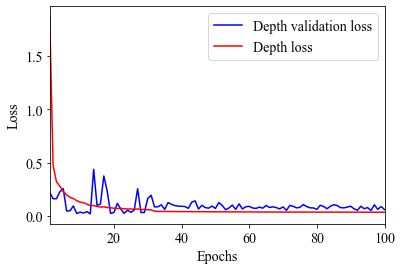

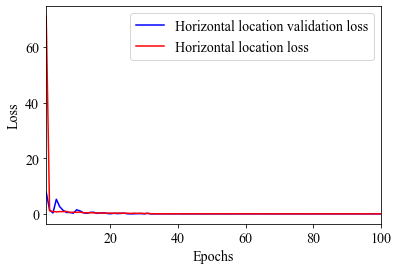

In [16]:
# plot Loss
epochs = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=0) + 1

iden_depth_val_loss = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=7)
iden_depth_loss = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=2)

iden_loc_val_loss = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=9)
iden_loc_loss = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=4)

###############################Identification depth loss and accuracy###################################
plt.rcParams['font.sans-serif'] =  'Times New Roman'
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(6, 4))
plt.plot(epochs,iden_depth_val_loss,'b')
# plt.title('Identification depth training loss')
plt.plot(epochs,iden_depth_loss,'r')
plt.xlim(1,args.epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Depth validation loss','Depth loss'])
plt.subplots_adjust(hspace=0.4)
plt.savefig('figures/loss_and_accuracy1.jpg',format='jpg',dpi=600)
plt.show()

###############################Identification location loss and accuracy###################################
plt.figure(figsize=(6, 4))
plt.plot(epochs,iden_loc_val_loss,'b')
# plt.title('Identification horizontal location training loss')
plt.plot(epochs,iden_loc_loss,'r')
plt.xlim(1,args.epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Horizontal location validation loss','Horizontal location loss'])
plt.subplots_adjust(hspace=0.4)
plt.savefig('figures/loss_and_accuracy2.jpg',format='jpg',dpi=600)
plt.show()

# 4、 Save model

In [17]:
# serialize model to JSON
model_json = model.to_json()
with open(save_dir+"\model.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model")
# serialize weights to HDF5
model.save_weights(save_dir+"\model.h5")
print("Saved weight")

Saved model
Saved weight


# 5、Model evaluation and test

In [18]:
def testdata_gen(test_data_dir = 'test_data/x',test_label_data_dir = 'test_data/y',rows=args.rows, columns=1):
    # 测试数据集的样本和真实标签的生成
    xs = datagenerator(test_data_dir, rows=args.rows, columns=1)
    xs = xs.astype('float32')
    # 归一化数据
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    for i_xs in range(xs.shape[0]):
        xs[i_xs] = scaler_x.fit_transform(xs[i_xs])
    testX=xs
    
    ys = datagenerator_label(test_label_data_dir)
    ys = ys.astype('float32')
    testY = ys # Becasue of classification, delete the second and third column.
    print("Updated Label's dimension :",testY.shape)
    
    print('testX.shape:',testX.shape)
    print('testY.shape:',testY.shape)
    
    return testX, testY[:,0], testY[:,1]

In [26]:
# evaluate model

# load test sample data
# testX, testY0, testY1 = testdata_gen(test_data_dir = '../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_test_1perc/x',test_label_data_dir = '../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_test_1perc/y',rows=args.rows, columns=1)
# testX, testY0, testY1 = testdata_gen(test_data_dir = '../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_test_2perc/x',test_label_data_dir = '../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_test_2perc/y',rows=args.rows, columns=1)
testX, testY0, testY1 = testdata_gen(test_data_dir = '../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_test_5perc/x',test_label_data_dir = '../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_test_5perc/y',rows=args.rows, columns=1)
# test model evaluation 
testY0_pred, testY1_pred = model.predict(testX)

print('\nLocation results : ', testY0_pred)
print('\nDepth results : ', testY1_pred)

# calculate error for location regression model
error_location = mean_absolute_error(testY0, testY0_pred)
print('\nTest location MAE error:', error_location)

# calculate error for depth regression model
error_depth = mean_absolute_error(testY1, testY1_pred)  # loss = mean(abs(y_true - y_pred), axis=-1)
print('\nTest depth MAE error:', error_depth)


Sample's dimension :  (20000, 200, 1)
^_^-Training sample data finished-^_^
Label's dimension :  (20000, 2)
^_^-Training Labels data finished-^_^
Updated Label's dimension : (20000, 2)
testX.shape: (20000, 200, 1)
testY.shape: (20000, 2)

Location results :  [[ 77.54877 ]
 [ 63.663864]
 [117.622375]
 ...
 [103.12457 ]
 [124.16284 ]
 [ 50.990044]]

Depth results :  [[10.272516 ]
 [ 8.381254 ]
 [13.261867 ]
 ...
 [ 5.0599403]
 [14.415789 ]
 [10.925071 ]]

Test location MAE error: 0.19109012

Test depth MAE error: 0.16891713


Mean -0.05809395
Standard deviation 0.24068855
Mean 0.03387117
Standard deviation 0.21542102


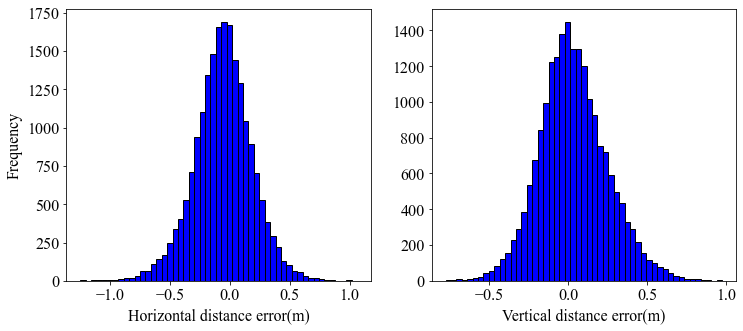

In [27]:
testY_loc_minus = [] #= testY_min_pred - testY_min
testY_depth_minus = [] #testY_max_pred - testY_max  
for i in range(testY0_pred.shape[0]):
    testY_loc_minus.append(testY0_pred[i,0] - testY0[i])
    testY_depth_minus.append(testY1_pred[i,0] - testY1[i])
        
# 绘制柱状分布图
plt.figure(figsize=(12,5))
plt.rcParams['font.sans-serif'] =  'Times New Roman'
plt.rcParams['font.size'] = '16'
plt.subplot(1,2,1)
plt.hist(testY_loc_minus,bins=51,rwidth=1,alpha=1, edgecolor='black', facecolor='blue')
print('Mean', np.mean(testY_loc_minus))
print('Standard deviation', np.std(testY_loc_minus))
# plt.xlim(-40,40)
plt.ylabel('Frequency')
plt.xlabel('Horizontal distance error(m)')

plt.subplot(1,2,2)
plt.hist(testY_depth_minus,bins=51,rwidth=1,alpha=1, edgecolor='black', facecolor='blue')
print('Mean', np.mean(testY_depth_minus))
print('Standard deviation', np.std(testY_depth_minus))
# plt.xlim(-40,40)
# plt.ylabel('Frequency')
plt.xlabel('Vertical distance error(m)')
plt.savefig('./figures/histgram_position.jpg',format='jpg',dpi=600)
plt.savefig('./figures/histgram_position.eps',format='eps',dpi=1000)
plt.show()

In [21]:
#可视化预测结果
def plot_images_labels_prediction(testX, testY1, testY2, testY1_pred, testY2_pred, column=200, index=0, num=8 ): 
    #testX,图像列表
    #column=200,输入图像时间序列维度                               
    #testY,标签列表
    #pred_Y, 预测值列表
    #index=0, 从第一个开始显示
    #num=5，缺省一次显示5幅
    fig = plt.gcf()  #获取当前图表，get current figure
    fig.set_size_inches(18, 6.5)
    if num > 10:
        num = 10
    for i in range(0, num):
        ax = plt.subplot(2, 3, i+1)  #获取当前要处理的子图
        ax.plot(np.array(range(1,column+1)), testX[index,:,0])
            
        title = '['+str(np.around(testY1[index],decimals=2)) + '],['+ str(np.around(testY2[index],decimals=2)) + ']'
        if len(testY0_pred) > 0:
            title = title + '-> Pred='+ str(np.around(testY1_pred[index],decimals=2)) + ','+ str(np.around(testY2_pred[index],decimals=2))
        
        ax.set_title(title, fontsize = 10)
        index += 1
    
    plt.subplots_adjust(hspace=0.4)
    plt.savefig('figures/images_labels_prediction.jpg',format='jpg',dpi=300)
    plt.show()

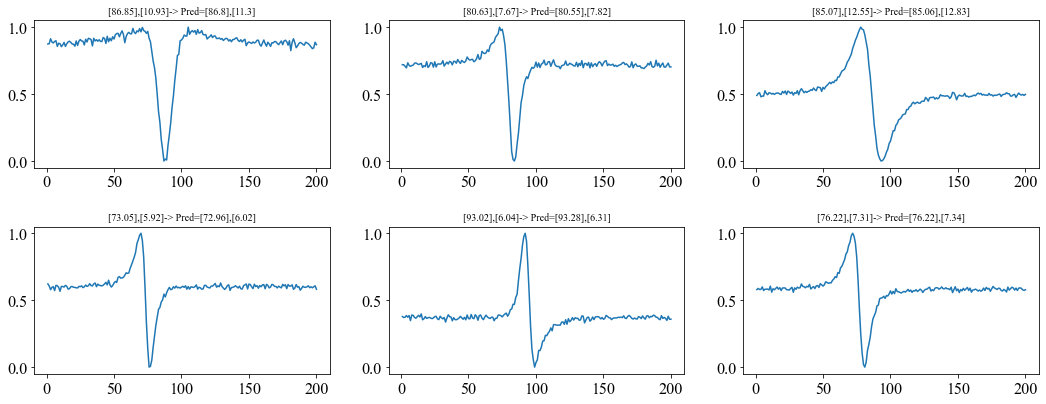

In [22]:
# model prediction
plot_images_labels_prediction(testX, testY0, testY1, testY0_pred, testY1_pred, column=args.time_series, index=20, num=6 )